In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("heart_disease.csv")

In [3]:
 df.shape

(908, 13)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,FALSE,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,FALSE,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,FALSE,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,FALSE,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,TRUE,1.5,flat,fixed defect,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       908 non-null    int64  
 1   sex       908 non-null    object 
 2   cp        908 non-null    object 
 3   trestbps  908 non-null    int64  
 4   chol      908 non-null    int64  
 5   fbs       908 non-null    bool   
 6   restecg   908 non-null    object 
 7   thalch    908 non-null    int64  
 8   exang     908 non-null    object 
 9   oldpeak   846 non-null    float64
 10  slope     908 non-null    object 
 11  thal      908 non-null    object 
 12  num       908 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 86.1+ KB


In [6]:
df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64

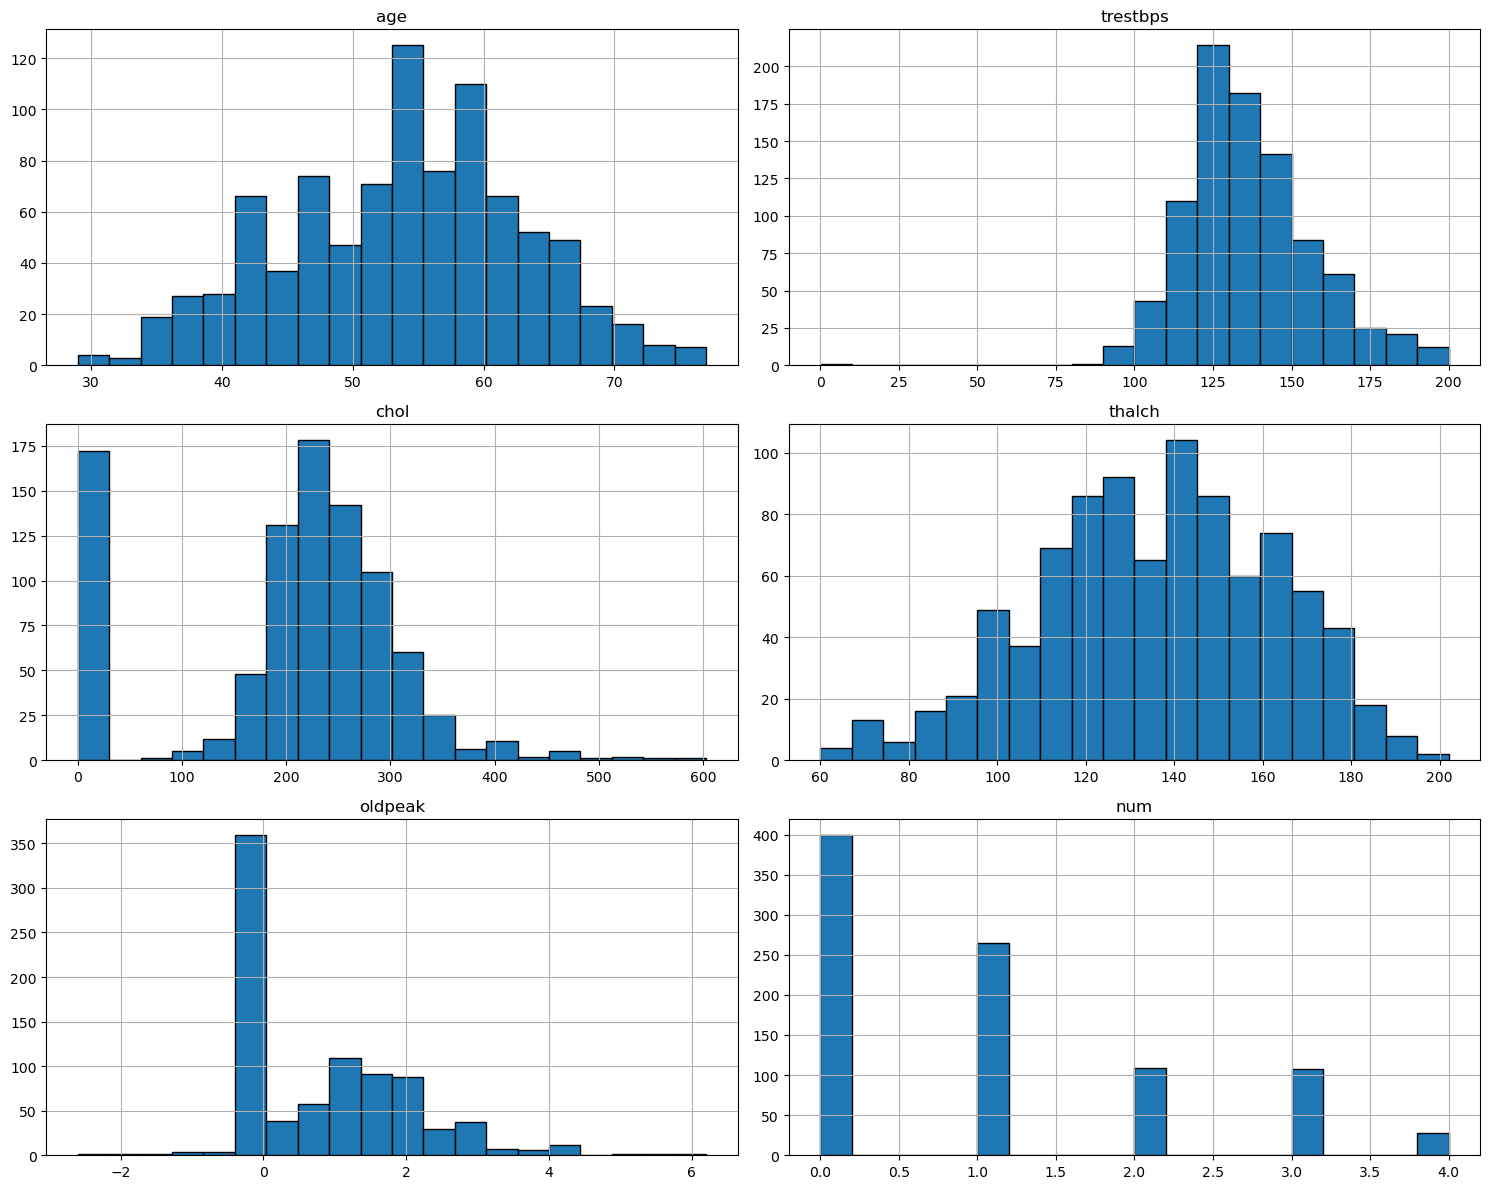

In [7]:
df.hist(figsize=(15, 12), bins=20, edgecolor="black")
plt.tight_layout()
plt.show()

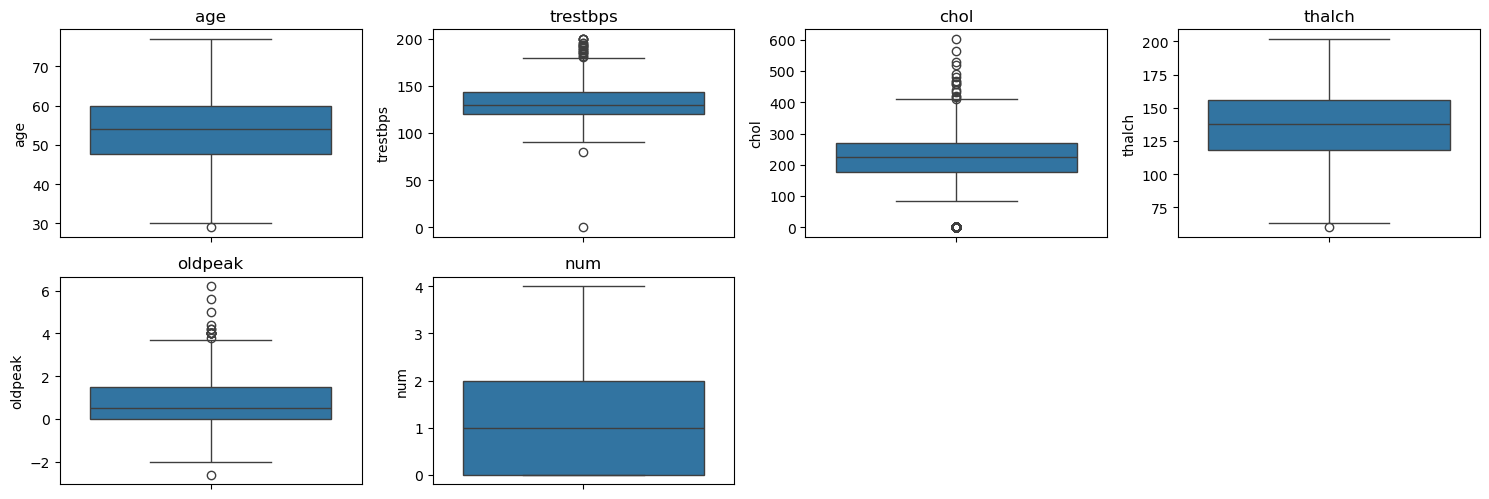

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.select_dtypes(include=np.number).columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

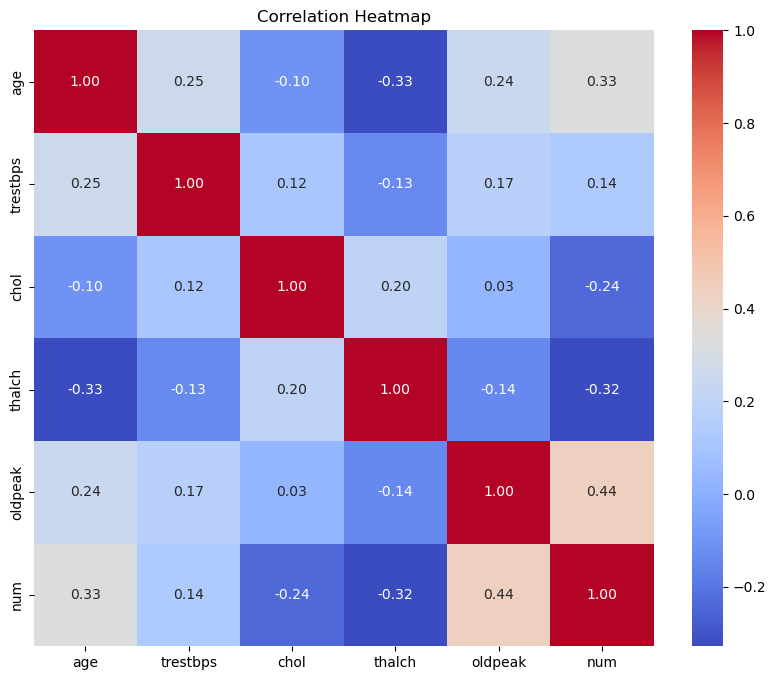

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [10]:
target_col = df.columns[-1]   # assume last column is target
X = df.drop(columns=[target_col])
y = df[target_col]

In [11]:
for col in X.columns:
    if X[col].dtype in ["int64", "float64"]:
        X[col].fillna(X[col].median(), inplace=True)  # numerical → median
    else:
        X[col].fillna(X[col].mode()[0], inplace=True) 

In [12]:
for col in X.columns:
    if X[col].dtype == "object":
        if X[col].nunique() == 2:  
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
        else:
            X = pd.get_dummies(X, columns=[col], drop_first=True)

print("Null values after preprocessing:", X.isnull().sum().sum())
print("Transformed feature set shape:", X.shape)

Null values after preprocessing: 0
Transformed feature set shape: (908, 18)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [14]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [15]:
y_pred = dt.predict(X_test)

In [16]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted', zero_division=0))

Accuracy: 0.4945054945054945
Precision: 0.4889598679708571
Recall: 0.4945054945054945
F1 Score: 0.49127595760248827


In [17]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [18]:
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [19]:
grid_search.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [20]:
print("\nBest Parameters:", grid_search.best_params_)
best_dt = grid_search.best_estimator_


Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [21]:
y_pred_best = best_dt.predict(X_test)

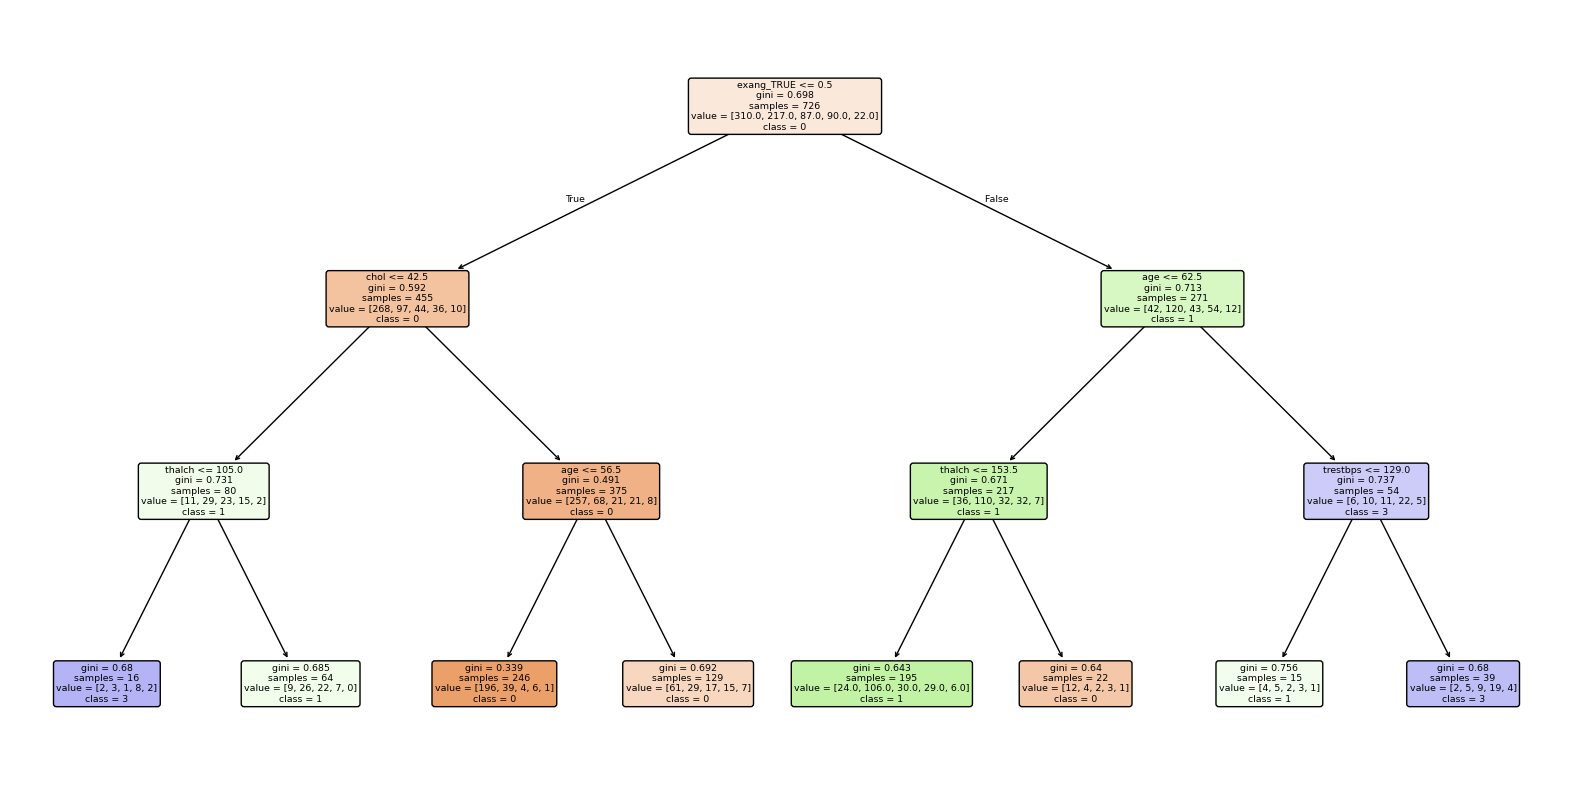

In [22]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X.columns, class_names=[str(cls) for cls in np.unique(y)], filled=True, rounded=True)
plt.show()

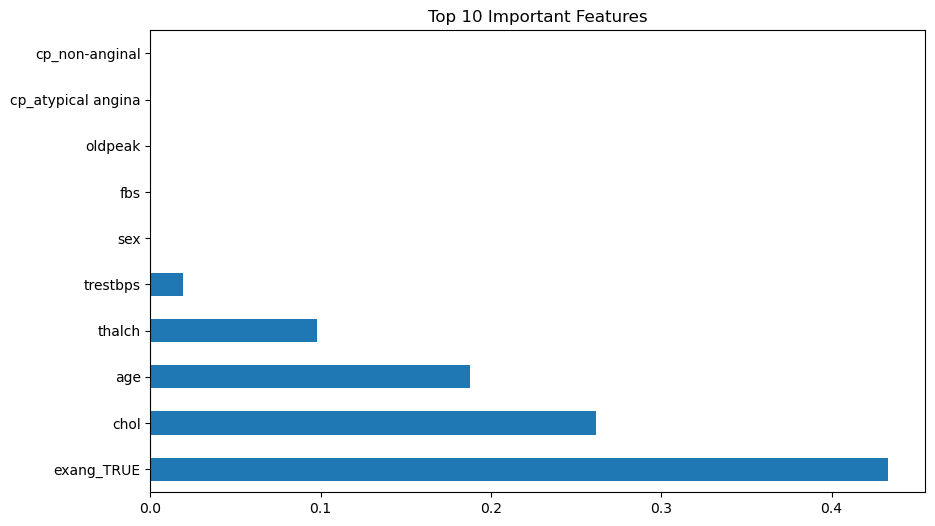

In [23]:
feat_importances = pd.Series(best_dt.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10,6))
plt.title("Top 10 Important Features")
plt.show()

interview Questions:

 Decision Tree Hyperparameters:

max_depth → controls depth (shallow = underfit, deep = overfit).

min_samples_split → min samples to split a node (higher = simpler tree).

min_samples_leaf → min samples per leaf (higher = less overfitting).

max_features → features to consider at split (reduces overfitting).

criterion → measure for split ("gini" / "entropy").

 Encoding:

Label Encoding → assigns numbers (Red=0, Blue=1, Green=2). May add false order.

One-Hot Encoding → creates binary columns ([1,0,0], [0,1,0], [0,0,1]). No order issue but increases columns.